# Amazon İncelemelerini Kullanarak Öneri Sistemleri

## 1. Kütüphaneleri import Et!

In [25]:
# Amazon İncelemelerini Kullanarak Öneri Sistemleri
import numpy as np # Lineer cebir
import pandas as pd # Veri işleme
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds



import warnings; warnings.simplefilter('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv


## 2. Veri Setini Yükle ve Başlıkları Adlandır!

In [5]:
veriSeti = pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",names=['kullaniciId', 'urunId','degerlendirme','zamanDamgasi'])

In [6]:
veriSeti.head(10)# ekrana gösterir.

,kullaniciId,urunId,degerlendirme,zamanDamgasi
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


In [7]:
veriSeti.shape# dizinin boyutunu ve şeklini belirliyoruz

(7824482, 4)

In [8]:
veriSeti = veriSeti.iloc[:1_000_000, 0:]# satır ve sütun indisleri kullanarak belirli bir veri aralığı seçiyoruz

In [9]:
veriSeti.dtypes #Dataframe'deki veri tiplerini gösteriyoruz.

kullaniciId       object
urunId            object
degerlendirme    float64
zamanDamgasi       int64
dtype: object

In [10]:
veriSeti.info() # Dataframe'in verilerinin özetini istiyoruz. Yani her sütunun ismi, veri tipi, boş olmayan veri sayısı vb.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   kullaniciId    1000000 non-null  object 
 1   urunId         1000000 non-null  object 
 2   degerlendirme  1000000 non-null  float64
 3   zamanDamgasi   1000000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 30.5+ MB


In [13]:
veriSeti.describe()['degerlendirme'] # Temel istatistik değerlerini getirir.

count    1000000.000000
mean           3.973620
std            1.399741
min            1.000000
25%            3.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: degerlendirme, dtype: float64

In [18]:
print("Minimum değerlendirme: %d" %(veriSeti.degerlendirme.min()))
print("Maksimum değerlendirme: %d" %(veriSeti.degerlendirme.max()))

Minimum değerlendirme: 1
Maksimum değerlendirme: 5


## 3. Boş Geçen Değerleri İşle!

In [20]:
#Her bir sütundaki eksik değerleri hesaplar. Eğer hücrede eksik değer varsa kontrol edip 
# True ya da False döndürür. Sum fonksiyonu ise her bir sütundaki True değerlerinin sayısını 
#hesaplayıp yazdırır.
print("Boş geçen sütunlar:\n", veriSeti.isnull().sum())

Boş geçen sütunlar:
 kullaniciId      0
urunId           0
degerlendirme    0
zamanDamgasi     0
dtype: int64


## 4. Değerlendirmeler!

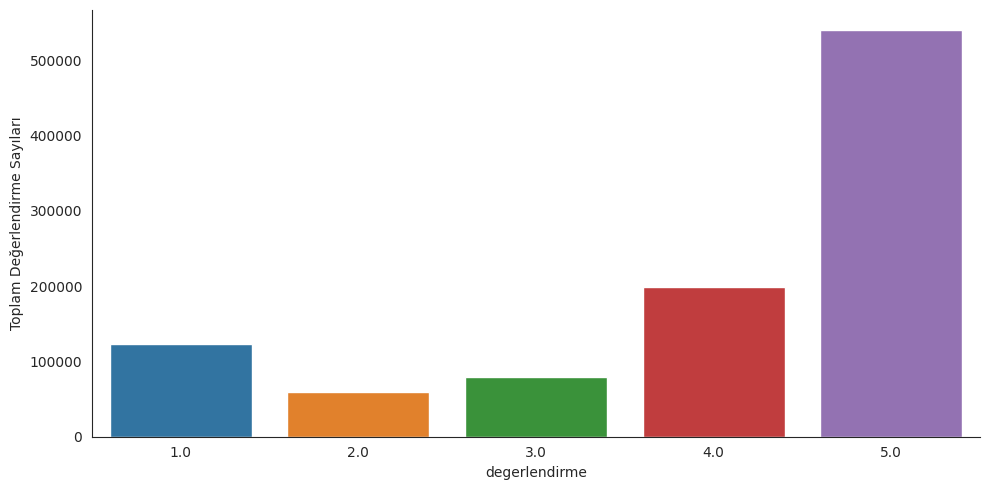

In [24]:
# aspect: çizimin genişlik/ yükseklik oranını ayarlar.
# kind: Çizim türünü belirtir. Bu örnekte 'count'
with sns.axes_style('white'):
    g = sns.catplot(x = "degerlendirme", data = veriSeti, aspect = 2.0, kind = 'count')
    g.set_ylabels("Toplam Değerlendirme Sayıları") # y ekseni

## 5. Unique Kullanıcılar ve Ürünler

In [26]:
print("Toplam Veri")
print("-" * 50)
print("\nToplam Değerlendirme Sayısı: ", veriSeti.shape[0])
print("\nToplam Kullanıcı Sayısı: ", len(np.unique(veriSeti.kullaniciId)))
print("\nToplam Ürün Sayısı", len(np.unique(veriSeti.urunId)))

Toplam Veri
--------------------------------------------------

Toplam Değerlendirme Sayısı:  1000000

Toplam Kullanıcı Sayısı:  754153

Toplam Ürün Sayısı 59634


## 6. Zaman Damgası Sütununu Bırakma

In [27]:
#Veri setimizden zamanDamgasi sütununu çıkartıyoruz.
# axis = 1 sütunlarda işlem yapacağımız anlamına geliyor.
# inplace = True, orijinal veri seti üzerinde işlem yapacağımız anlamına geliyor.
veriSeti.drop(["zamanDamgasi"], axis = 1, inplace = True)

## 7. Değerlendirmeleri Analiz Aşaması

In [28]:
#Kullanıcıların verdiği değerlendirmelerin analizi
kullaniciBasinaPuanlananUrunSayisi = veriSeti.groupby(by = 'kullaniciId')['degerlendirme'].count().sort_values(ascending = False)
kullaniciBasinaPuanlananUrunSayisi.head(10)

kullaniciId
A5JLAU2ARJ0BO     409
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      138
AT6CZDCP4TRGA     125
AKT8TGIT6VVZ5     122
A11D1KHM7DVOQK    112
A2B7BUH8834Y6M    103
A3OXHLG6DIBRW8     94
A2R6RA8FRBS608     88
Name: degerlendirme, dtype: int64

In [30]:
kullaniciBasinaPuanlananUrunSayisi.describe() # istatistiksel sonuçları istiyoruz.

count    754153.000000
mean          1.325991
std           1.372250
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         409.000000
Name: degerlendirme, dtype: float64

In [32]:
yuzdelik = kullaniciBasinaPuanlananUrunSayisi.quantile(np.arange(0, 1.01, 0.01), interpolation = 'higher')
#interpolation eksik veya bozuk olan değerleri hesaplamak için kullanıyoruz.

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Nicelikler ve Değerleri')

<AxesSubplot: title={'center': 'Nicelikler ve Değerleri'}>

Text(0, 0.5, 'Kullanıcı Başına Puanlanan Ürün Sayısı')

Text(0.5, 0, 'Yüzdelikteki Değerler')

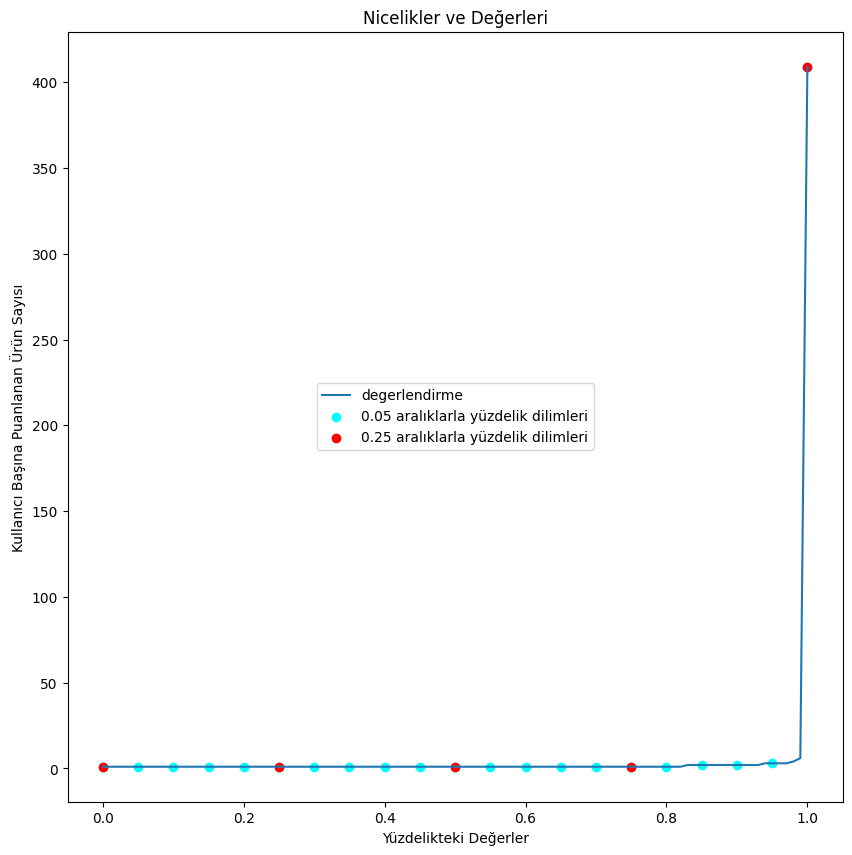

In [39]:
plt.figure(figsize = (10, 10))
plt.title("Nicelikler ve Değerleri")
yuzdelik.plot()
#0.05 farkla yüzdelikler
plt.scatter(x = yuzdelik.index[::5], y = yuzdelik.values[::5], c = "cyan", label = "0.05 aralıklarla yüzdelik dilimleri")
#0.25
plt.scatter(x = yuzdelik.index[::25], y = yuzdelik.values[::25], c = "red", label = "0.25 aralıklarla yüzdelik dilimleri")
plt.ylabel("Kullanıcı Başına Puanlanan Ürün Sayısı")
plt.xlabel("Yüzdelikteki Değerler")
plt.legend(loc = "center")
plt.show()

In [40]:
print("\n Kullanıcı başına 50'den fazla değerlendirilmiş ürün sayısı: {}\n".format(sum(kullaniciBasinaPuanlananUrunSayisi >= 50)))


 Kullanıcı başına 50'den fazla değerlendirilmiş ürün sayısı: 37



### Popülarite Bazlı Öneri Sistemi

In [41]:
new_df=veriSeti.groupby("urunId").filter(lambda x:x['degerlendirme'].count() >=50)
#50 veya daha fazla değerlendirme vermiş kullanıcıları içeren yeni veri seti oluşturuyoruz.

Text(0.5, 1.0, 'Ürün Başına DEĞERLENDİRME')

Text(0.5, 0, 'Ürün')

Text(0, 0.5, 'Ürün Başına Değerlendirme Sayısı')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, '')]

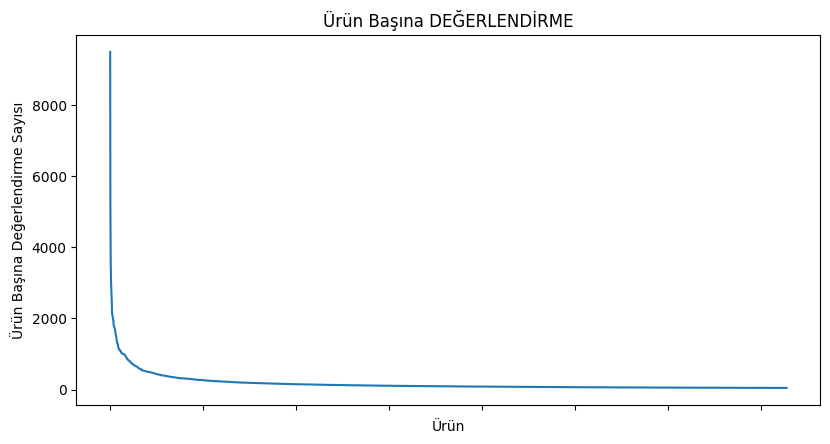

In [44]:
urunBasinaDegerlendirmeSayisi = new_df.groupby("urunId")["degerlendirme"].count().sort_values(ascending = False)

fig = plt.figure(figsize = plt.figaspect(.5))
ax = plt.gca()
plt.plot(urunBasinaDegerlendirmeSayisi.values)
plt.title("Ürün Başına DEĞERLENDİRME")
plt.xlabel("Ürün")
plt.ylabel("Ürün Başına Değerlendirme Sayısı")
ax.set_xticklabels([])
plt.show()

In [48]:
# Ortalama Ürün Değerlendirmesini bulalım.
new_df.groupby('urunId')['degerlendirme'].mean().sort_values(ascending = False).head()

urunId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B0002E52S4    4.861111
Name: degerlendirme, dtype: float64

In [49]:
#Ürün Toplam Değerlendirme Sayısını bulalım.
new_df.groupby('urunId')['degerlendirme'].count().sort_values(ascending = False).head(10)

urunId
B0002L5R78    9487
B0001FTVEK    5345
B000BQ7GW8    4275
B00007E7JU    3523
B000BKJZ9Q    3219
B000B9RI14    2996
B000A6PPOK    2828
B00007M1TZ    2608
B00004ZCJE    2547
B000CSWCQA    2441
Name: degerlendirme, dtype: int64

In [52]:
#Değerlendirmelerin ortalamasının sayısını değişkende tutalım. Bu değişkene bir veri seti yapalım.
ortalamaDegerlendirmeSayisi = pd.DataFrame(new_df.groupby('urunId')['degerlendirme'].mean())
ortalamaDegerlendirmeSayisi

,degerlendirme
urunId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211
...,...
B000HDMUU8,4.543860
B000HDONV2,4.507042
B000HDONWQ,3.981818


In [59]:
#OrtalamaDegerlendirmeSayisi'na degerlendirmeSayilari adında bir sütun oluşturalım.
ortalamaDegerlendirmeSayisi['degerlendirmeSayilari'] = pd.DataFrame(new_df.groupby('urunId')['degerlendirme'].count())
ortalamaDegerlendirmeSayisi.head(10)

,degerlendirme,degerlendirmeSayilari
urunId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
1400532655,3.727273,484
140053271X,3.900232,431
1400532736,3.904762,84
1400599997,3.490991,222


In [89]:
ortalamaDegerlendirmeSayisi['degerlendirmeSayilari'].sort_values(ascending = False)
print("\n\nEn Çok Değerlendirilmiş Ürünün Değerlendirme Sayısı: {}".format(ortalamaDegerlendirmeSayisi['degerlendirmeSayilari'].max()))
butunUrunlerinOrtalamaDegerlendirmeSayisi = ortalamaDegerlendirmeSayisi['degerlendirme'].mean()
print("\n\nBütün Ürünlerin Ortalama Değerlendirme Sayısı: {}".format(butunUrunlerinOrtalamaDegerlendirmeSayisi))

urunId
B0002L5R78    9487
B0001FTVEK    5345
B000BQ7GW8    4275
B00007E7JU    3523
B000BKJZ9Q    3219
              ... 
B00008JOMD      50
B00020E4QO      50
B0000CG4DI      50
B0006ZO2CG      50
B000FOI2TW      50
Name: degerlendirmeSayilari, Length: 3639, dtype: int64



En Çok Değerlendirilmiş Ürünün Değerlendirme Sayısı: 9487


Bütün Ürünlerin Ortalama Değerlendirme Sayısı: 3.967948612959947


<Figure size 800x600 with 0 Axes>

<AxesSubplot: >

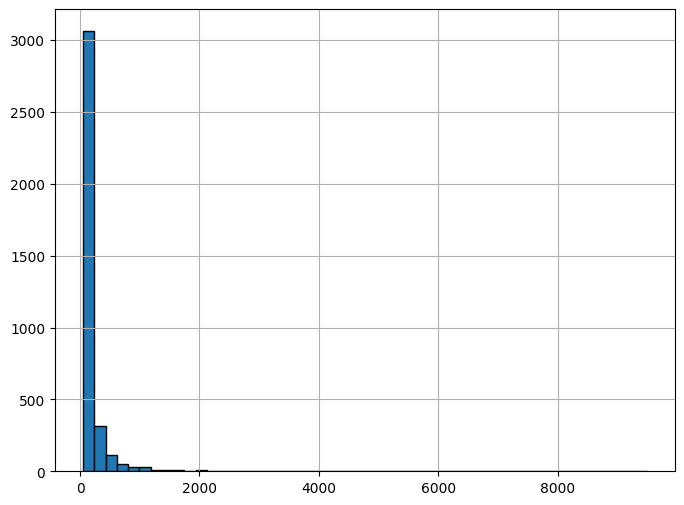

In [64]:
plt.figure(figsize = (8, 6)) #figsize: yükseklik ve genişlik belirtir. 8geniş, 6 yüks
plt.rcParams['patch.force_edgecolor'] = True # grafiğin çerçevisi görünür olması (edge)
ortalamaDegerlendirmeSayisi['degerlendirmeSayilari'].hist(bins = 50) #bins: çubuk sayısı

<Figure size 800x600 with 0 Axes>

<AxesSubplot: >

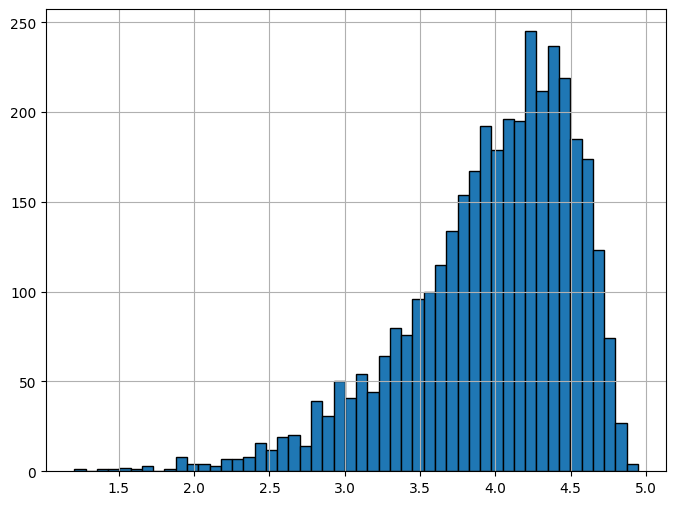

In [67]:
plt.figure(figsize = (8, 6))
plt.rcParams['patch.force_edgecolor'] = True
ortalamaDegerlendirmeSayisi['degerlendirme'].hist(bins = 50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

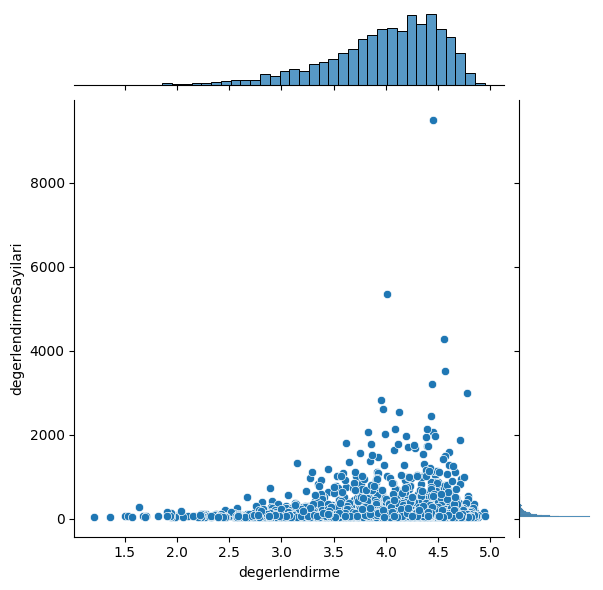

In [76]:
plt.figure(figsize = ( 8, 6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x = 'degerlendirme', y = 'degerlendirmeSayilari', data = ortalamaDegerlendirmeSayisi, alpha = 1)

<AxesSubplot: xlabel='urunId'>

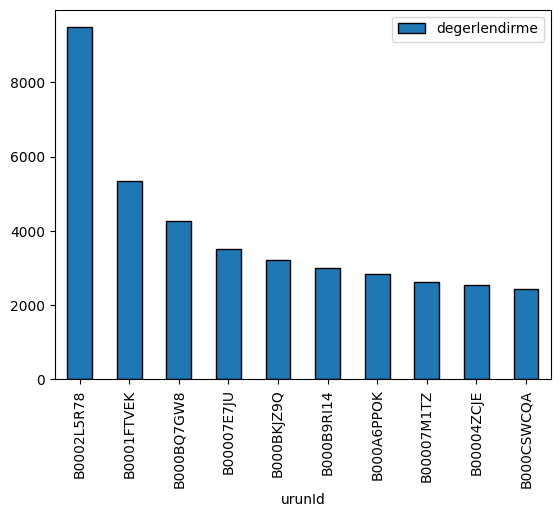

In [77]:
populerUrunler = pd.DataFrame(new_df.groupby('urunId')['degerlendirme'].count())
enPopuler = populerUrunler.sort_values('degerlendirme', ascending = False)
enPopuler.head(10).plot(kind = "bar")